# Сегментация экземпляров на предобученной Mask R-CNN

In [31]:
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from collections import Counter
from prettytable import PrettyTable

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
COCO_CLASSES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
    'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A',
    'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [4]:
model = maskrcnn_resnet50_fpn(pretrained=True).to(device)
model.eval()

def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    tensor = F.to_tensor(image).unsqueeze(0).to(device)
    return image, tensor

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 149MB/s]


In [5]:
image_path = '/content/5c4758fd13986d88d1f8de53c4a2a9ac.jpg'
original_image, image_tensor = load_image(image_path)

with torch.no_grad():
    predictions = model(image_tensor)

In [6]:
predictions

[{'boxes': tensor([[501.0683, 104.0613, 822.8962, 617.4282],
          [421.6191, 333.1363, 924.8895, 664.6057],
          [  6.1252, 291.5116, 454.1360, 534.9758],
          [936.6524, 148.9121, 965.1103, 208.0072],
          [526.7546, 154.4726, 664.9818, 264.9386],
          [902.6962, 348.0525, 922.8242, 405.2363],
          [277.8669, 294.8050, 327.2823, 337.4569],
          [ 68.1765, 267.3530, 545.0771, 463.5821],
          [939.0319, 361.2310, 951.6330, 390.5112],
          [503.2597, 163.5716, 686.5453, 329.9394],
          [442.6920, 306.1231, 505.9576, 338.7917],
          [900.2105, 281.8972, 921.8316, 305.8221],
          [ 50.0113, 264.7500,  74.1766, 296.0517],
          [439.4327, 303.1748, 555.4344, 385.8346],
          [  6.9997, 296.2522, 225.8971, 367.1370],
          [ 79.0768, 271.5895, 509.3497, 378.7071],
          [898.3315, 268.9297, 929.4089, 308.8457],
          [924.1382, 151.3256, 941.2523, 204.5097],
          [914.9938, 389.0353, 936.0038, 422.6008],
   

## Задача 1

Модифицируйте код сегментации экземпляров на предобученной Mask R-CNN, чтобы он обнаруживал только объекты определенных классов (например, только людей и автомобили).

In [7]:
def filter_prediction(prediction, target_ids, score_threshold=0.5):
    labels = prediction['labels']
    scores = prediction['scores']
    boxes = prediction['boxes']
    masks = prediction['masks']

    keep = [(labels[i].item() in target_ids) and (scores[i].item() >= score_threshold)
            for i in range(len(labels))]

    filtered = {
        'labels': labels[keep],
        'scores': scores[keep],
        'boxes': boxes[keep],
        'masks': masks[keep]
    }
    return filtered

def visualize_filtered(image, prediction, alpha=0.5):
    pred = {k: v.cpu() for k, v in prediction.items()}
    image_np = np.array(image)
    masks = (pred['masks'] > alpha).squeeze(1).numpy()
    colored_mask = np.zeros_like(image_np, dtype=np.uint8)
    for mask in masks:
        color = np.random.randint(0, 255, size=3)
        colored_mask[mask] = color
    result = cv2.addWeighted(image_np, 1-alpha, colored_mask, alpha, 0)
    plt.figure(figsize=(12, 8))
    plt.imshow(result)
    plt.axis('off')
    plt.show()

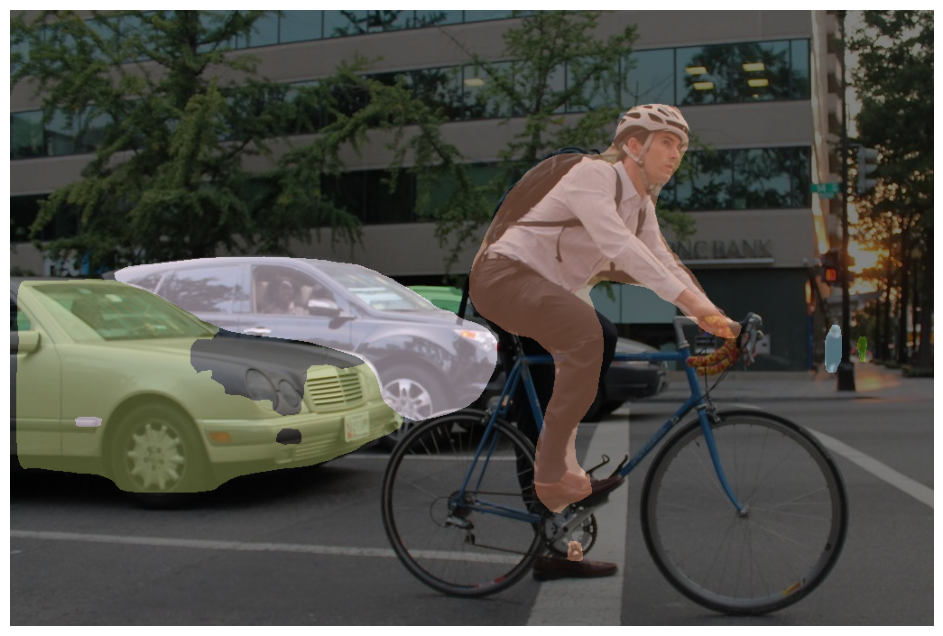

In [9]:
TARGET_CLASSES = ['person', 'car']
TARGET_IDS = [COCO_CLASSES.index(cls) for cls in TARGET_CLASSES]

filtered_preds = filter_prediction(predictions[0], TARGET_IDS, score_threshold=0.7)
visualize_filtered(original_image, filtered_preds)

In [11]:
filtered_preds['labels']

tensor([1, 3, 1, 1, 3, 1, 3])

## Задача 2 + Задача 5

Добавьте отрисовку bounding box поверх масок (используйте cv2.rectangle). Сделайте разные цвета для разных классов.

Замените случайные цвета на фиксированные для каждого класса (люди – красные, машины – синие и т.д.). Используйте словарь class_colors.

In [20]:
def visualize_boxes(image, prediction, class_colors, alpha=0.5, box_thickness=2):
    pred = {k: v.cpu() for k, v in prediction.items()}
    image_np = np.array(image).copy()

    masks = (pred['masks'] > alpha).squeeze(1).numpy()
    labels = pred['labels'].numpy()
    boxes = pred['boxes'].numpy().astype(int)

    colored_mask = np.zeros_like(image_np, dtype=np.uint8)
    for mask, label in zip(masks, labels):
        color = class_colors.get(int(label), (0, 255, 0))
        colored_mask[mask] = color

    overlay = cv2.addWeighted(image_np, 1 - alpha, colored_mask, alpha, 0)

    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = box
        color = class_colors.get(int(label), (0, 255, 0))
        cv2.rectangle(overlay, (x1, y1), (x2, y2), color, thickness=box_thickness)

    plt.figure(figsize=(12, 8))
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()

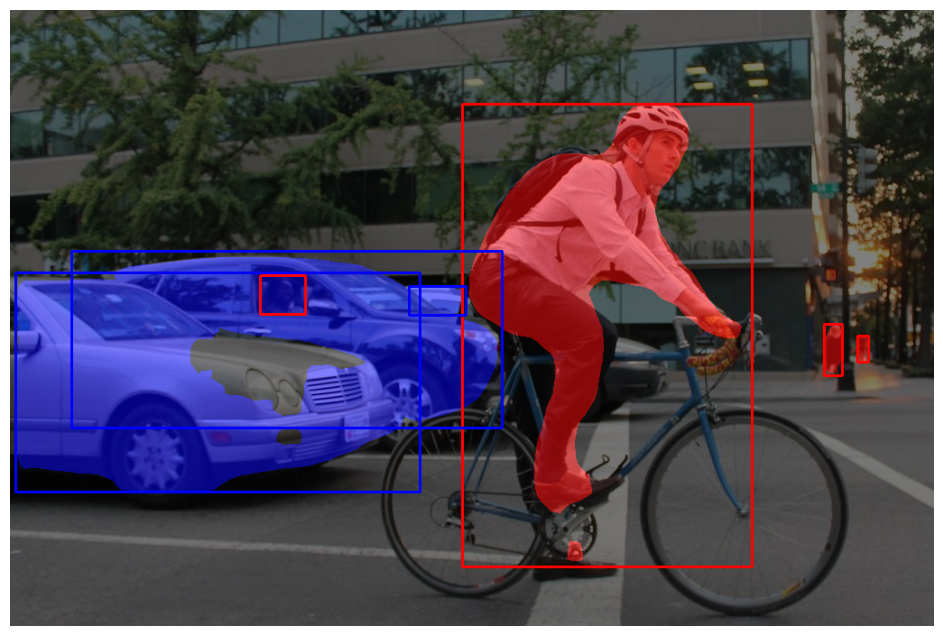

In [23]:
class_colors = {
    3: (0, 0, 255), #person
    1: (255, 0, 0) #car
}

visualize_boxes(original_image, filtered_preds, class_colors)

## Задача 3

Реализуйте подсчет количества обнаруженных объектов каждого класса (вывод в консоль таблицы: класс → количество).

In [32]:
def count_instances(prediction, score_threshold=0.5):
    labels = prediction['labels'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()

    cnt = Counter()
    for lbl, scr in zip(labels, scores):
        if scr >= score_threshold:
            cls_name = COCO_CLASSES[lbl]
            cnt[cls_name] += 1

    table = PrettyTable()
    table.field_names = ["Класс", "Количество"]
    for cls, num in cnt.items():
        table.add_row([cls, num])

    print(table)

In [33]:
count_instances(filtered_preds)

+--------+------------+
| Класс  | Количество |
+--------+------------+
| person |     4      |
|  car   |     3      |
+--------+------------+


In [34]:
count_instances(predictions[0])

+---------------+------------+
|     Класс     | Количество |
+---------------+------------+
|     person    |     4      |
|    bicycle    |     1      |
|      car      |     3      |
| traffic light |     2      |
|    backpack   |     2      |
+---------------+------------+


## Задача 4 (не сделал)

Модифицируйте код для обработки видеофайла (по кадрам) с сохранением результата.

## Задача 6 (не сделал)

Добавьте сохранение бинарных масок для каждого объекта (PNG) и аннотаций в COCO-формате (JSON)